In [42]:
# Data loading 

import numpy as np
import cv2
import glob
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GroupKFold, GroupShuffleSplit
import matplotlib.pyplot as plt
cmap_data = plt.cm.Paired
%matplotlib

Using matplotlib backend: Qt5Agg


In [13]:
files

['..\\data\\train\\XR_HAND\\patient00008\\study1_positive\\image1.png',
 '..\\data\\train\\XR_HAND\\patient00008\\study1_positive\\image2.png',
 '..\\data\\train\\XR_HAND\\patient00008\\study1_positive\\image3.png',
 '..\\data\\train\\XR_HAND\\patient00050\\study1_negative\\image1.png',
 '..\\data\\train\\XR_HAND\\patient00050\\study1_negative\\image2.png',
 '..\\data\\train\\XR_HAND\\patient00050\\study1_negative\\image3.png',
 '..\\data\\train\\XR_HAND\\patient00051\\study1_negative\\image1.png',
 '..\\data\\train\\XR_HAND\\patient00051\\study1_negative\\image2.png',
 '..\\data\\train\\XR_HAND\\patient00084\\study1_positive\\image1.png',
 '..\\data\\train\\XR_HAND\\patient00084\\study1_positive\\image2.png',
 '..\\data\\train\\XR_HAND\\patient00097\\study1_negative\\image1.png',
 '..\\data\\train\\XR_HAND\\patient00097\\study1_negative\\image2.png',
 '..\\data\\train\\XR_HAND\\patient00097\\study1_negative\\image3.png',
 '..\\data\\train\\XR_HAND\\patient00126\\study1_positive\\image

## Train-val-test split

In [47]:
class TrainValTestSplitter:

    def __init__(self, path_to_data='..\\data\\train\\XR_HAND\\*\\*\\*', show_labels_dist=False):
        self.data = pd.DataFrame()
        self.data['path'] = glob.glob(path_to_data)
        self.data['label'] = self.data['path'].apply(lambda path: len(re.findall('positive', path)))
        self.data['patient'] = self.data['path'].apply(lambda path: re.findall('[0-9]{5}', path)[0])
        if show_labels_dist:
            self.data['label'].hist()
            plt.title('Labels distribution')
            plt.show()
        self._split_data()

    def _split_stats(self, df):
        print(f'Size: {len(df)}')
        print(f'Percentage from original data: {len(df)/len(self.data)}')
        print(f'Percentage of negatives: {len(df[df.label == 0])/len(df)}')
        print(f'Number of patients: {len(df.patient.unique())}')

    def _split_data(self) -> tuple:
        # train | validate test split
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
        negative_data = self.data[self.data.label == 0]
        generator = splitter.split(negative_data.label, groups=negative_data['patient'])
        idx_train, idx_validate_test = next(generator)

        print('=================Train subset=================')
        self.data_train = negative_data.iloc[idx_train, :].reset_index(drop=True)
        self._split_stats(self.data_train)

        # validate | test split
        data_val_test = pd.concat([self.data[self.data.label == 1],
                                   self.data.iloc[negative_data.iloc[idx_validate_test, :].index]])
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
        generator = splitter.split(data_val_test.label, groups=data_val_test['patient'])
        idx_val, idx_test = next(generator)

        print('=============Validation subset===============')
        self.data_val = data_val_test.iloc[idx_val, :]
        self.data_val = self.data_val.sample(len(self.data_val)).reset_index(drop=True)
        self._split_stats(self.data_val)

        print('=================Test subset=================')
        self.data_test = data_val_test.iloc[idx_test, :]
        self.data_test = self.data_test.sample(len(self.data_test)).reset_index(drop=True)
        self._split_stats(self.data_test)

In [48]:
splitter = TrainValTestSplitter()

=================Train subset=================
Size: 3855
Percentage from original data: 0.695471766191593
Percentage of negatives: 1.0
Number of patients: 1381
=============Validation subset===============
Size: 859
Percentage from original data: 0.15497023272596067
Percentage of negatives: 0.11525029103608847
Number of patients: 294
=================Test subset=================
Size: 829
Percentage from original data: 0.14955800108244632
Percentage of negatives: 0.12665862484921592
Number of patients: 295


In [40]:
n_points = 100

percentiles_split = [.7, .15, .15]
train_classes = [1, .0]
val_classes = [0.5, 0.5]
test_classes = [0.5, 0.5]

split = np.hstack([[ii] * int(1000 * perc) for ii, perc in enumerate(percentiles_split)])
train_classes = np.hstack([[ii] * int(700 * perc) for ii, perc in enumerate(train_classes)])
val_classes = np.hstack([[ii] * int(150 * perc) for ii, perc in enumerate(val_classes)])
test_classes = np.hstack([[ii] * int(150 * perc) for ii, perc in enumerate(test_classes)])
groups = np.hstack([[ii] * 10 for ii in range(100)])


def visualize_groups(split, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize = (15, 5))
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_', lw=50, cmap='gist_ncar',
                  edgecolor='black')
    train_size = int(percentiles_split[0]*len(groups))
    val_size = int(percentiles_split[1]*len(groups)) 
    test_size = int(percentiles_split[2]*len(groups))

    ax.axvline(695, ymin=0.1, ymax=0.9)
    ax.axvline(845, ymin=0.1, ymax=0.9)
    
    ax.scatter(range(train_size), [2] * train_size, c=train_classes, marker='_', lw=50, cmap='Set2')
    ax.scatter(range(train_size, train_size+val_size),  [2] * val_size, c=val_classes, marker='_', lw=50, cmap='Set2')
    ax.scatter(range(train_size+val_size, train_size+val_size+test_size),  [2] * test_size, c=val_classes, marker='_', lw=50, cmap='Set2')
    ax.text(10, 2, 'Negative')
    ax.text(705, 2, 'Negative')
    ax.text(780, 2, 'Positive')
    ax.text(855, 2, 'Negative')
    ax.text(930, 2, 'Positive')
    
    
    ax.scatter(range(len(groups)),  [3.5] * len(groups), c=split, marker='_', lw=50, cmap=cmap_data)
    ax.text(10, 3.4, 'Train', fontsize=15)
    ax.text(705, 3.4, 'Validation', fontsize=15)
    ax.text(855, 3.4, 'Test', fontsize=15)
    
    
    ax.set(ylim=[-1, 5], yticks=[.5, 2.0, 3.5], xticks = range(-5, 1100, 100), xticklabels = range(0, 110, 10),
           yticklabels=['Patients', 'Data\nclasses', 'Split'], xlabel="Percentage")
    ax.set_title('Validation strategy', fontsize=20)

visualize_groups(split, groups, 'no groups')

## Data Generator

In [41]:
class DataGenerator():
    'Generates data'
    def __init__(self, filenames, batch_size=16, dim=(512, 512), n_channels=1, shuffle=True, true_labels=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.filenames = filenames
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.input_shape = (self.batch_size, self.n_channels, *self.dim)
        self.true_labels = np.array(true_labels)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        if index == -1:
            index = len(self) - 1
        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_filenames_temp = [self.filenames[k] for k in indexes]

        # Generate data
        X = self.__data_generation(list_filenames_temp)

        return X
    
    def get_true_labels(self):
        return self.true_labels[self.indexes[0:len(self)*self.batch_size]]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_filenames_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty(self.input_shape)

        # Generate data
        for i, filename in enumerate(list_filenames_temp):
            # Store sample
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.copyMakeBorder(img, 0, 512 - img.shape[0], 0, 512 - img.shape[1], cv2.BORDER_CONSTANT, value = 0)
            img = cv2.resize(img, self.dim)
            img = img * 1/255
            X[i,0,:,:] = img

        return X

## PyTorch model

In [52]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score

In [53]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(), 
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.MaxPool2d(2)
        )
        
        self.decoder = nn.Sequential(    
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Tanh())
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [81]:
train_generator = DataGenerator(filenames=splitter.data_train.path[0:128], batch_size=32, dim=(64, 64))
val_generator = DataGenerator(filenames=splitter.data_val.path[0:64], batch_size=32, dim=(64, 64), 
                              true_labels=splitter.data_val.label)

In [82]:
model = Autoencoder().cpu()
inner_loss = nn.MSELoss()
outer_loss = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [83]:
from tqdm import tqdm_notebook
from torchsummary import summary
summary(model, input_size=(train_generator.n_channels, *train_generator.dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 32, 32, 32]           8,224
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]          32,832
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11            [-1, 128, 8, 8]         131,200
             ReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]         147,584
             ReLU-14            [-1, 12

In [84]:
num_epochs = 100
for epoch in range(num_epochs):
    
    for batch in tqdm_notebook(range(len(train_generator))):
        inp = Variable(torch.from_numpy(train_generator[batch]).float()).cpu()
            
        # forward pass
        output = model(inp)
        loss = inner_loss(output, inp)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # log
    print('epoch [{}/{}], loss on last train batch:{:.4f}'.format(epoch+1, num_epochs, loss.data))
    
    # shuffle
    train_generator.on_epoch_end()
    
    #the last train image
    with torch.no_grad():
        inp_image = train_generator[-1][-1:]
        inp = torch.from_numpy(inp_image).float()
        output = model(inp)
        output_img = output.numpy()[0][0]
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (5, 10)) 
        ax[0].imshow(inp_image[0][0])
        ax[1].imshow(output_img)
        plt.show()
        
    #validation
    with torch.no_grad():
        losses = []
        for batch in tqdm_notebook(range(len(val_generator))):
            inp = Variable(torch.from_numpy(val_generator[batch]).float()).cpu()

            # forward pass
            output = model(inp)
            losses.extend(outer_loss(output, inp).numpy().mean(axis=(1, 2, 3)))
        losses = np.array(losses)
        true_labels = val_generator.get_true_labels()
        
        # ROC-AUC
        print(f'ROC-AUC on val: {roc_auc_score(y_true=true_labels, y_score=losses)}')
        
        # MSE
        print(f'MSE on val: {losses.mean()}')
        
        # F1-score
        precision, recall, thresholds = precision_recall_curve(y_true=true_labels, probas_pred=losses)
        f1_scores = (2 * precision * recall / (precision + recall))
        opt_treshold = thresholds[np.argmax(f1_scores)]
        print(f'F1-score: {np.max(f1_scores)}. Optimal treshold: {opt_treshold}')


epoch [1/100], loss on last train batch:0.0307


KeyboardInterrupt: 

In [65]:
pd.DataFrame(np.array([losses, true_labels]).T, columns=['MSE', 'True label']).head(15)

,MSE,True label
0,0.021799,1.0
1,0.010138,1.0
2,0.020005,1.0
3,0.028688,1.0
4,0.015813,1.0
5,0.038689,1.0
6,0.013173,1.0
7,0.022707,1.0
8,0.046933,0.0
9,0.010739,1.0


In [73]:
from torchviz import make_dot
from graphviz import Digraph
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

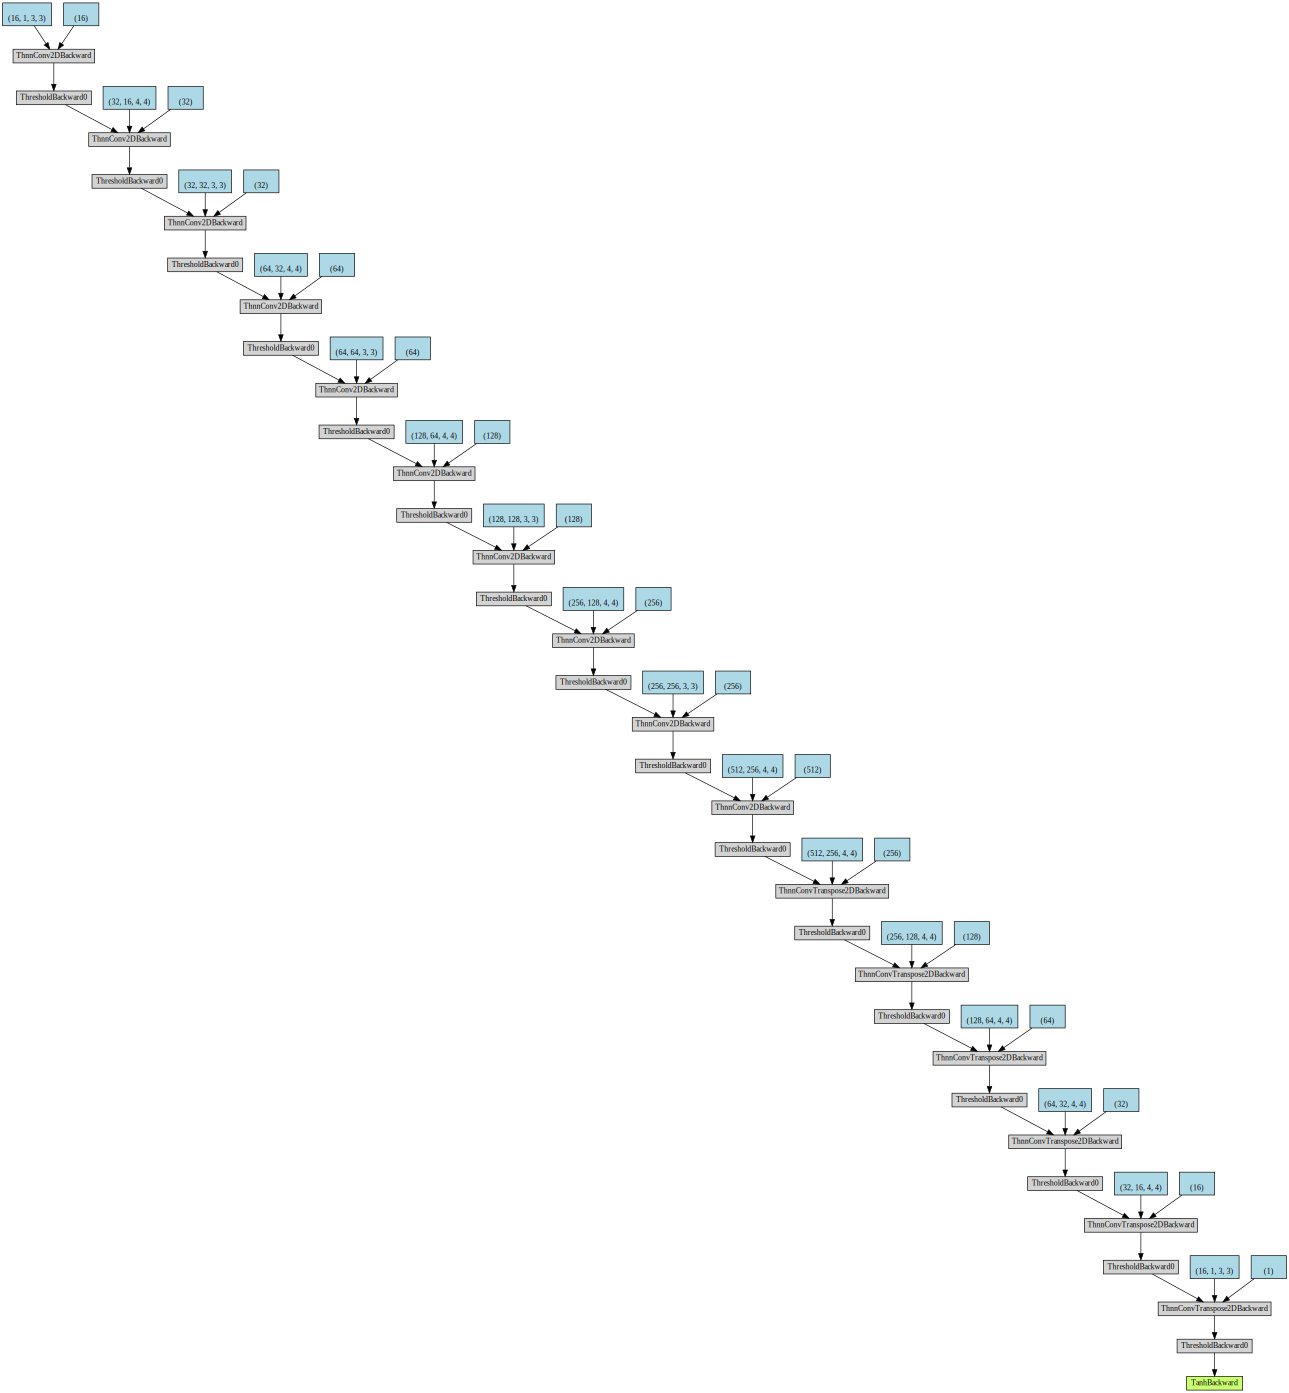

In [80]:
make_dot(output)